In [1]:
!pip3 install shapely

     |████████████████████████████████| 2.0 MB 1.7 MB/s            


In [2]:
import shapely as shp
from shapely.geometry import box, Point, Polygon, LineString, MultiLineString
from shapely.affinity import scale
from shapely.ops import unary_union
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator

import pdb

Matplotlib is building the font cache; this may take a moment.


# Definitions

In [3]:
class Building:
    def __init__(self, building_type, door, blocks=None, bbox=None):
        self.building_type = building_type
        self.door = door
    
        # Calculate the bounding box of the building
        if blocks:
            min_x = min([block[0] for block in blocks])
            min_y = min([block[1] for block in blocks])
            max_x = max([block[0]+1 for block in blocks])
            max_y = max([block[1]+1 for block in blocks])
            bbox = box(min_x, min_y, max_x, max_y)
        elif bbox:
            blocks=[]
            for x in range(int(bbox.bounds[0]), int(bbox.bounds[2])):
                for y in range(int(bbox.bounds[1]), int(bbox.bounds[3])):
                    blocks += [(x,y)]
        else:
            raise ValueError("Either blocks spanned or bounding box must be provided.")
        
        self.blocks = blocks
        self.geometry = bbox
        

class Street:
    def __init__(self, coordinates):
        self.coordinates = coordinates
        self.neighbors_streets = []
        self.neighbors_buildings = []
        self.geometry = box(coordinates[0], coordinates[1], coordinates[0]+1, coordinates[1]+1)
        
    def add_neighbor(self, neighbor):
        if neighbor is None or not check_adjacent(self.geometry, neighbor.geometry):
            return False
        if isinstance(neighbor, Street):
            self.neighbors_streets.append(neighbor)
            return True
        if isinstance(neighbor, Building) and neighbor.door == self.coordinates:
            self.neighbors_buildings.append(neighbor)
            return True
        return False
        
class City:
    def __init__(self, dimensions=(0, 0)):
        self.buildings = {}
        self.streets = {}
        self.buildings_outline = Polygon()
        self.address_book = {}
        self.street_graph = {}
        
        if not (isinstance(dimensions, tuple) and len(dimensions) == 2 and all(isinstance(d, int) for d in dimensions)):
            raise ValueError("Dimensions must be a tuple of two integers.")               
        self.city_boundary = box(0, 0, dimensions[0], dimensions[1])

        for x in range(0, dimensions[0]):
            for y in range(0, dimensions[1]):
                self.streets[(x, y)] = Street((x, y))
        self.dimensions = dimensions
        
    def add_building(self, building_type, door, blocks=None, bbox=None):
        building = Building(building_type, door, blocks, bbox)
        
        combined_plot = unary_union([building.geometry, self.streets[door].geometry])
        if self.buildings_outline.contains(combined_plot) or self.buildings_outline.overlaps(combined_plot):
            raise ValueError("New building or its door overlap with existing buildings.")    
            
        if not check_adjacent(building.geometry, self.streets[door].geometry):
            raise ValueError(f"Door {door} must be adjacent to new building.")
                    
        # add building
        self.buildings[(door, building_type)] = building
        self.buildings_outline = unary_union([self.buildings_outline, building.geometry])        
        
        # blocks are no longer streets
        for block in building.blocks:
            self.address_book[block] = building
            del self.streets[block]
        
        # Expand city boundary?
        buffered_building_geom = building.geometry.buffer(1)
        if not self.city_boundary.contains(buffered_building_geom):
            new_boundary = self.city_boundary.union(buffered_building_geom).envelope
            self.city_boundary = new_boundary
            self.dimensions = (int(new_boundary.bounds[2]), int(new_boundary.bounds[3]))
            # Update the streets for any new blocks within the expanded boundary
            minx, miny, maxx, maxy = map(int, new_boundary.bounds)
            for x in range(minx, maxx+1):
                for y in range(miny, maxy+1):
                    if (x, y) not in self.streets:
                        # Initialize new Street objects for the expanded city area
                        self.streets[(x, y)] = Street((x, y))
            
    def get_element(self, coordinates):
        # Return None if coordinates are outside the city
        x, y = coordinates
        bx, by = self.dimensions
        if (x < 0 or x >= bx or y < 0 or y >= bx):
            return None
        
        if coordinates in self.address_book:
            return self.address_book[coordinates]
        else:
            return self.streets[coordinates]
        
    # Determine adjacent streets and buildings for each street block and construct graph
    def get_adjacencies(self):
        for x, y in self.streets.keys():
            street = self.streets[(x, y)]
            neighbors = [
                (x, y + 1),  
                (x, y - 1),  
                (x + 1, y),  
                (x - 1, y)   
            ]

            for neighbor in neighbors:
                block = city.get_element(neighbor)
                street.add_neighbor(block)
        
        # Construct graph of streets
        self.street_graph = {block: [] for block in self.streets.keys()}
        for street in self.street_graph.keys(): 
            self.street_graph[street] = [neighbor.coordinates for neighbor in self.get_element(street).neighbors_streets]

    def save(self, filename):
        """Save the city object to a file."""
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
            
    def plot_city(self, ax, doors=True, address=True, filename=None, zorder=1):
        # Draw city boundary
        x, y = self.city_boundary.exterior.xy
        ax.plot(np.array(x), np.array(y), linewidth=2, color='black')  # Dashed line for the boundary

        # Define colors for different building types
        colors = {
            'home': 'skyblue',
            'work': '#C9A0DC',
            'retail': 'lightgrey',
            'park': 'lightgreen'
        }

        # Draw buildings
        for building in self.buildings.values():
            x, y = building.geometry.exterior.xy
            ax.fill(x, y, facecolor=colors[building.building_type], edgecolor='black', linewidth=0.5, 
                    label=building.building_type.capitalize(), zorder=zorder)
            
            #plot doors
            if doors:
                door_line = building.geometry.intersection(self.streets[building.door].geometry)
                scaled_door_line = scale(door_line, xfact=0.25, yfact=0.25, origin=door_line.centroid)
                dx, dy = scaled_door_line.xy
                ax.plot(dx, dy, linewidth=2, color='white', zorder=zorder)
                
            if address:
                door_coord = building.door
                
                bbox = ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
                axes_width_in_inches = bbox.width
                axes_data_range = ax.get_xlim()[1] - ax.get_xlim()[0]
                fontsize = (axes_width_in_inches / axes_data_range) * 13  # Example scaling factor
                
                ax.text(door_coord[0] + 0.15, door_coord[1] + 0.15, f"{door_coord[0]},{door_coord[1]}", 
                ha='left', va='bottom', fontsize=fontsize, color='black')

        ax.set_aspect('equal')
        # Set integer ticks
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        
        if filename is not None:
            plt.savefig(filename)
            
def load(filename):
    """Load a city object from a file."""
    with open(filename, 'rb') as file:
        return pickle.load(file)

def save(city, filename):
    """Save the city object to a file."""
    with open(filename, 'wb') as file:
        pickle.dump(city, file)    

def check_adjacent(geom1, geom2):
    intersection = geom1.intersection(geom2)
    return isinstance(intersection, (LineString, MultiLineString))


In [ ]:
class Agent:
    def __init__(self, home, workplace):
        self.home = home
        self.workplace = workplace
    
    # add diary

# Initialize city

In [4]:
# Initialize city
city = City(dimensions=(22, 22))

# add park
city.add_building('park', (13,11), bbox=box(9,9,13,13))

# add homes
city.add_building('home', (8,8), [(7,7), (7,8)])
city.add_building('home', (9,8), [(8,7), (9,7)])
city.add_building('home', (10,8), [(10,7)])
city.add_building('home', (11,8), [(11,7)])
city.add_building('home', (13,6), [(13,7)])
city.add_building('home', (14,6), [(14,7)])
city.add_building('home', (13,8), [(14,8)])
city.add_building('home', (13,9), [(14,9)])
city.add_building('home', (13,11), [(14,11)])
city.add_building('home', (13,12), [(14,12)])
city.add_building('home', (15,13), [(14,13)])
city.add_building('home', (13,13), [(13,14),(14,14)])
city.add_building('home', (12,13), [(12,14)])
city.add_building('home', (11,13), [(11,14)])
city.add_building('home', (9,13), [(9,14)])
city.add_building('home', (8,13), [(8,14)])
city.add_building('home', (7,15), [(7,14)])
city.add_building('home', (6,13), [(7,13)])
city.add_building('home', (8,12), [(7,12)])
city.add_building('home', (8,10), [(7,10), (7,9)])

# add workplaces
city.add_building('work', (3,4), [(4,4), (4,5)])
city.add_building('work', (5,3), [(5,4), (5,5)])
city.add_building('work', (6,6), bbox=box(6,4,8,6))
city.add_building('work', (8,6), bbox=box(8,4,10,6))
city.add_building('work', (12,6), bbox=box(11,5,14,6))
city.add_building('work', (12,3), bbox=box(11,4,14,5))
city.add_building('work', (15,3), bbox=box(14,4,17,6))
city.add_building('work', (18,4), bbox=box(17,4,18,6))
city.add_building('work', (18,6), bbox=box(16,6,18,8))
city.add_building('work', (15,9), bbox=box(16,8,17,10))
city.add_building('work', (18,8), bbox=box(17,8,18,10))
city.add_building('work', (18,10), bbox=box(16,10,18,12))
city.add_building('work', (18,13), bbox=box(16,13,18,15))
city.add_building('work', (18,15), bbox=box(16,15,18,16))
city.add_building('work', (15,15), bbox=box(15,16,18,17))
city.add_building('work', (14,15), [(14,16)])
city.add_building('work', (16,18), bbox=box(16,17,18,18))
city.add_building('work', (15,18), bbox=box(14,17,16,18))
city.add_building('work', (13,18), bbox=box(12,16,14,18))
city.add_building('work', (11,18), bbox=box(10,17,12,18))
city.add_building('work', (11,15), bbox=box(10,16,12,17))
city.add_building('work', (8,18), bbox=box(7,16,9,18))
city.add_building('work', (6,18), bbox=box(5,17,7,18))
city.add_building('work', (6,15), bbox=box(5,16,7,17))
city.add_building('work', (3,16), [(4,16),(4,17)])
city.add_building('work', (3,13), bbox=box(4,13,6,16))
city.add_building('work', (6,12), bbox=box(4,12,6,13))
city.add_building('work', (3,10), [(4,9),(4,10)])
city.add_building('work', (6,9), [(5,9),(5,10)])
city.add_building('work', (6,8), [(4,8),(5,8)])
city.add_building('work', (3,6), bbox=box(4,6,6,8))

# add retail
city.add_building('retail', (0,1), bbox=box(1,1,3,3))
city.add_building('retail', (3,0), bbox=box(3,1,5,3))
city.add_building('retail', (5,0), [(5,1)])
city.add_building('retail', (5,3), [(5,2)])
city.add_building('retail', (6,0), bbox=box(6,1,8,2))
city.add_building('retail', (6,3), bbox=box(6,2,8,3))
city.add_building('retail', (9,3), bbox=box(9,1,10,3))
city.add_building('retail', (12,3), bbox=box(10,1,13,3))
city.add_building('retail', (14,3), bbox=box(13,1,15,3))
city.add_building('retail', (15,3), [(15,2)])
city.add_building('retail', (16,3), [(16,2)])
city.add_building('retail', (15,0), [(15,1)])
city.add_building('retail', (16,0), [(16,1)])
city.add_building('retail', (17,3), bbox=box(17,2,19,3))
city.add_building('retail', (18,0), bbox=box(17,1,19,2))
city.add_building('retail', (19,0), bbox=box(19,1,21,2))
city.add_building('retail', (18,3), bbox=box(19,2,21,4))
city.add_building('retail', (18,5), bbox=box(19,4,21,6))
city.add_building('retail', (18,7), bbox=box(19,6,20,8))
city.add_building('retail', (21,7), bbox=box(20,6,21,8))
city.add_building('retail', (18,10), bbox=box(19,9,21,11))
city.add_building('retail', (18,11), bbox=box(19,11,21,13))
city.add_building('retail', (18,13), bbox=box(19,13,20,15))
city.add_building('retail', (21,13), bbox=box(20,13,21,15))
city.add_building('retail', (21,16), bbox=box(19,15,21,17))
city.add_building('retail', (21,18), bbox=box(19,17,21,19))

city.add_building('retail', (21,19), bbox=box(19,19,21,20))
city.add_building('retail', (20,21), bbox=box(19,20,21,21))
city.add_building('retail', (17,18), bbox=box(17,19,18,21))
city.add_building('retail', (16,18), bbox=box(16,19,17,21))
city.add_building('retail', (14,18), bbox=box(13,19,16,20))
city.add_building('retail', (15,21), bbox=box(14,20,16,21))
city.add_building('retail', (13,21), bbox=box(12,20,14,21))
city.add_building('retail', (12,18), bbox=box(12,19,13,20))
city.add_building('retail', (11,18), bbox=box(10,19,12,21))
city.add_building('retail', (9,18), bbox=box(8,19,10,20))
city.add_building('retail', (9,21), bbox=box(8,20,10,21))
city.add_building('retail', (6,21), bbox=box(5,19,7,21))
city.add_building('retail', (4,21), bbox=box(3,20,5,21))
city.add_building('retail', (4,18), bbox=box(3,19,5,20))
city.add_building('retail', (2,18), bbox=box(2,19,3,21))
city.add_building('retail', (1,18), bbox=box(1,19,2,21))
city.add_building('retail', (3,17), bbox=box(1,16,3,18))
city.add_building('retail', (3,15), bbox=box(1,15,3,16))
city.add_building('retail', (3,14), bbox=box(1,14,3,15))
city.add_building('retail', (3,12), bbox=box(1,12,3,14))
city.add_building('retail', (3,11), bbox=box(1,11,3,12))
city.add_building('retail', (3,10), bbox=box(1,10,3,11))
city.add_building('retail', (3,8), bbox=box(1,8,3,10))
city.add_building('retail', (3,7), bbox=box(1,7,3,8))
city.add_building('retail', (0,5), bbox=box(1,4,2,7))
city.add_building('retail', (3,6), [(2,6)])
city.add_building('retail', (3,5), [(2,5)])
city.add_building('retail', (3,4), [(2,4)])

city.get_adjacencies()
city.save('garden-city.pkl')

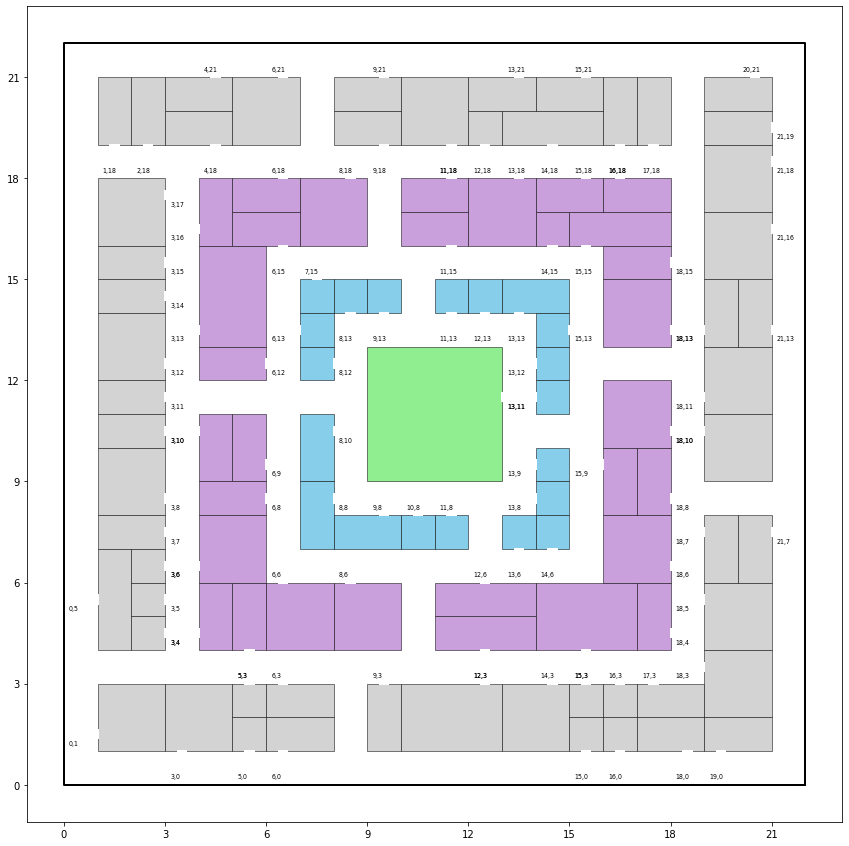

In [5]:
fig, ax = plt.subplots(figsize=(15,15))
city.plot_city(ax, doors=True, address=True)

In [6]:
# list all streets
city.streets.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (1, 0), (1, 3), (1, 18), (1, 21), (2, 0), (2, 3), (2, 18), (2, 21), (3, 0), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 21), (4, 0), (4, 3), (4, 11), (4, 18), (4, 21), (5, 0), (5, 3), (5, 11), (5, 18), (5, 21), (6, 0), (6, 3), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 18), (6, 21), (7, 0), (7, 3), (7, 6), (7, 11), (7, 15), (7, 18), (7, 19), (7, 20), (7, 21), (8, 0), (8, 1), (8, 2), (8, 3), (8, 6), (8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 15), (8, 18), (8, 21), (9, 0), (9, 3), (9, 6), (9, 8), (9, 13), (9, 15), (9, 16), (9, 17), (9, 18), (9, 21), (10, 0), (10, 3), (10, 4), (10, 5), (10, 6), (10, 8), (10, 13), (10, 14), (10, 15), (10, 1

[(10, 1), (10, 2), (11, 1), (11, 2), (12, 1), (12, 2)]


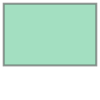

In [7]:
# identify a building by its door coordinates and building type
print(city.buildings[((12,3),'retail')].blocks)
city.buildings[((12,3),'retail')].geometry

# Trajectory Simulation

In [100]:
import pandas as pd
import numpy.random as npr
from datetime import datetime

def traj_stay(building, n, sigma, p, dt=1):
    """
    Generate an instance of two-dimensional Brownian motion constrained within a building
    with some probability of staying still.
    
    The Weiner process is given by X(t) = N(0, sigma^2 * t), 
    or iteratively as X(t + dt) = X(t) + N(0, sigma^2 * dt).
    
    Arguments
    ---------
    building: Building 
        building within which to generate trajectory 
    n: int 
        number of points to generate (initial position + n-1 steps)
    sigma: float 
        "speed" of the Brownian motion.  The random variable X(t) of the position at 
        time t has a normal distribution with mean 0 and variance sigma^2 * t.
    p: float, 0 <= p <= 1
        probability of staying still
    dt: float
        time step (n*dt gives the duration of the stay)

    Returns
    -------
    A numpy array of floats with shape (n,2) with initial position at the building door.
    """
    
    bbox = building.geometry
    door = building.geometry.intersection(city.streets[building.door].geometry) 
    
    out = np.empty((n,2))
    point = ((door.coords[0][0] + door.coords[1][0]) / 2, (door.coords[0][1] + door.coords[1][1]) / 2)
    out[0,:] = point
    stay_probs = np.random.binomial(1, p, n)
    
    for t in range(n-1):
        
        # move with probability 1-p
        if stay_probs[t] == 0:
            
            r = np.random.normal(loc=0, scale=sigma * np.sqrt(dt), size=2)
            point = out[t,:] + r

            # redraw if new point falls outside building
            while not bbox.contains(Point(point)):
                r = np.random.normal(loc=0, scale=sigma * np.sqrt(dt), size=2)
                point = out[t,:] + r
            
        out[t+1,:] = point
        
    return out

def BFS_shortest_path(graph, start, end):
    """
    Computes the shortest path between a start and end street block.
    
    Arguments
    ---------
    graph: dict
        undirected graph with streets as vectices and edges between adjacent streets
    start: tuple
        coordinates of starting street (i.e., door of start building)
    end: tuple
        coordinates of ending street (i.e., door of end building)
    
    Returns
    -------
    A list denoting the shortest path of street blocks going from the start to the end.
    """
    
    explored = []
    queue = [[start]]
    
    if start == end:
        return [start]
     
    while queue:
        path = queue.pop(0)
        node = path[-1]
         
        if node not in explored:
            neighbors = graph[node]
             
            for neighbor in neighbors:
                new_path = list(path)
                new_path.append(neighbor)
                queue.append(new_path)
                 
                if neighbor == end:
                    return new_path
            explored.append(node)
 
    print("Path does not exist.")
    return None

# compute path once for every pair of building -> save it as attribute of city then query

def traj_move(start, end, speed=50):
    """
    Generate a move between two buildings, constrained to the streets.
    
    Arguments
    ---------
    start: Building
    end: Building
    speed: double
        speed in meters/minute (each block is 15m by 15m)

    Returns
    -------
    A numpy array of floats with shape (n,2).
    """
    # maybe a probability of staying still (eg red lights)

    start = start.door
    end = end.door
    path = BFS_shortest_path(graph=city.street_graph, start=start, end=end)
    pathml = MultiLineString([path])

    dist = pathml.length
    totaltime = dist*15/speed

    traj = np.empty((int(totaltime)+1,2))

    for t in range(int(totaltime)+1):
        frac = dist * t/totaltime
        traj[t,] = pathml.interpolate(frac).coords
        
    return traj + 0.5 # put trajectory in middle of street
    
def simulate_traj(stays, moves, seed=None):
    """
    Simulate a trajectory.

    Parameters
    ----------
    stays : list of tuples
        A list of tuples, each representing a stay. Each tuple consists of three elements:
        - building (Building): The building the user is staying at
        - t (int): The duration of the stay in time units.
        - p (float): The probability of staying still (0 <= p <= 1)
    moves : list of int
        A list of integers specifying the duration of each move between stays. The length of this list
        must be one less than the length of `stays`.
    seed : int
        The seed for random number generation.
        
    Returns
    -------
    A numpy array with columns 'x', 'y', 'local_timestamp', 'unix_timestamp', 'identifier'
    """
    
    if seed:
        npr.seed(seed)
    else:
        seed = npr.randint(0,1000,1)[0]
        npr.seed(seed)
        print("Seed:", seed)
        
    traj = np.empty((0,2))
    n_stays = len(stays)
    
    for i in range(n_stays):
    
        (building, time, p_still) = stays[i]
        
        corners = building.geometry.exterior.coords
        shortest_side = min(abs(corners[0][0]-corners[1][0]+corners[0][1]-corners[1][1]), 
                            abs(corners[1][0]-corners[2][0]+corners[1][1]-corners[2][1]))
        # proportional to area? 
        # or just have a sigma for home, one for retail, etc.
        stay_traj = traj_stay(building, time, sigma=shortest_side/1.96, p=p_still)
        
        if (i+1 < n_stays):
            move_traj = traj_move(stays[i][0], stays[i+1][0])
            traj = np.concatenate((traj, stay_traj, move_traj), axis=0)
        else:
            traj = np.concatenate((traj, stay_traj), axis=0)
    
    df = pd.DataFrame(traj, columns = ['x', 'y'])
    df['local_timestamp'] = pd.to_datetime([datetime(2022, 1, 1, int(t//60), int(t%60)).isoformat() for t in range(len(traj))])
    df['unix_timestamp'] = (df['local_timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    df['identifier'] = 'User X'
    
    return df


In [97]:
start = city.buildings[((8,13), 'home')]
end = city.buildings[((12,3), 'retail')]
speed=60

start = start.door
end = end.door
path = BFS_shortest_path(graph=city.street_graph, start=start, end=end)
pathml = MultiLineString([path])

dist = pathml.length
totaltime = dist*15/speed

traj = np.empty((int(totaltime)+1,2))

for t in range(int(totaltime)+1):
    frac = dist * t/totaltime
    traj[t,] = pathml.interpolate(frac).coords

In [91]:
def traj_move_helper(t, pathml, totaltime, dist):
    frac = dist * t/totaltime

print(pathml)

MULTILINESTRING ((8 13, 8 12, 8 11, 8 10, 8 9, 8 8, 9 8, 10 8, 11 8, 12 8, 12 7, 12 6, 11 6, 10 6, 10 5, 10 4, 10 3, 11 3, 12 3))


range(0, 4)

In [101]:
stays = [(city.buildings[((8,13), 'home')],   30,  0.6), 
         (city.buildings[((12,3), 'retail')], 60,  0.2),
         (city.buildings[((15,15),'work')],   180, 0.9),
         (city.buildings[((8,13), 'home')],   60,  0.6)]

# stays are sequences of buildings every 15 minutes (same consecutive = longer stay), no need for duration param
# how to handle streets? start traveling when a change happens, if travel more than 15 min, then keep going 
# (need to handle if change destination in middle of move)

# attributes of class Population with Agents (with location sequence and trajectory)
# City has attributes sigma, p (associated with each Building type), maybe larger sigma for streets if we end up doing that

# automatically calculate move duration based on length of path
moves = [15, 25, 10]

traj = simulate_traj(stays, moves, seed=100)
traj

,x,y,local_timestamp,unix_timestamp,identifier
0,8.500000,14.000000,2022-01-01 00:00:00,1640995200,User X
1,8.500000,14.000000,2022-01-01 00:01:00,1640995260,User X
2,8.500000,14.000000,2022-01-01 00:02:00,1640995320,User X
3,8.500000,14.000000,2022-01-01 00:03:00,1640995380,User X
4,8.594142,14.478103,2022-01-01 00:04:00,1640995440,User X
...,...,...,...,...,...
340,8.640994,14.847818,2022-01-01 05:40:00,1641015600,User X
341,8.640994,14.847818,2022-01-01 05:41:00,1641015660,User X
342,8.640994,14.847818,2022-01-01 05:42:00,1641015720,User X
343,8.640994,14.847818,2022-01-01 05:43:00,1641015780,User X


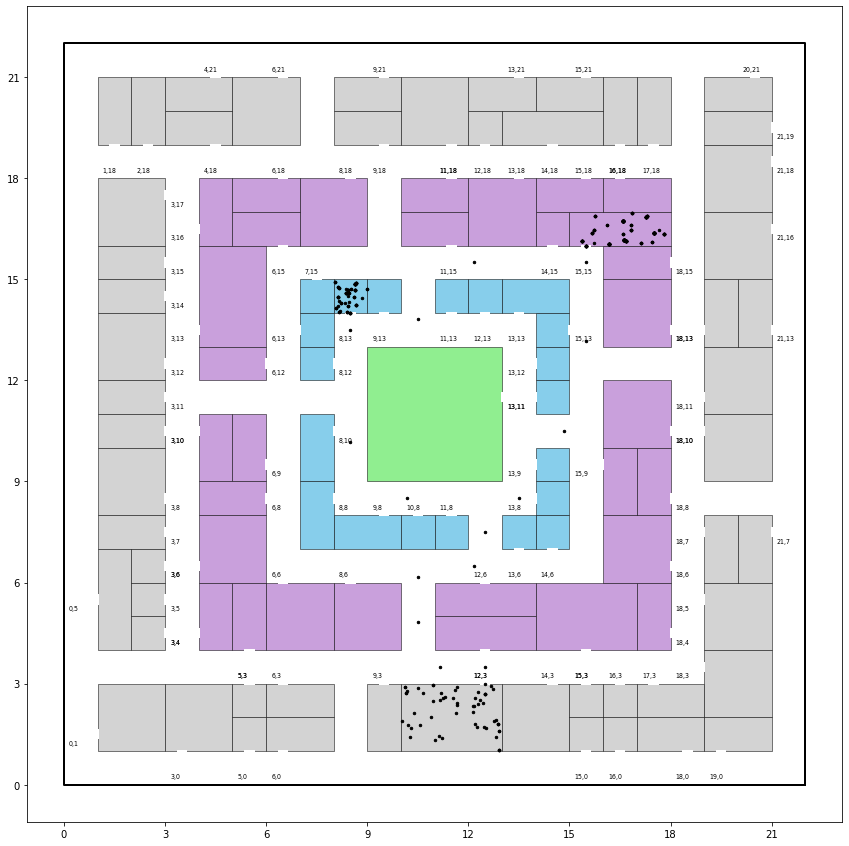

<Figure size 432x288 with 0 Axes>

In [102]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(traj.x, traj.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, filename="garden-city-one-user.png", zorder=1)

# savefig is not working -- need to figure this out... (added a line to the plot_city function)